In [ ]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization
importlib.reload(data)

QNT_Count = 14 # even, so it splits 0
QNT_Bounds = 0.1
CLASS_Labels = data.quantized_labels(QNT_Count, QNT_Bounds)

Assets = pd.DataFrame(index=['df', 'column', 'LSTM', 'train_X_y'], columns=['SOL-30m'], dtype='object')

Assets.at['df', 'SOL-30m'] = data.load_asset('SOLUSDT', sampling='30m')

for key in Assets.columns:
    df = Assets.loc['df', key].copy()
    df = data.subset(df, start=pd.Timestamp('2024-06-01'), end=pd.Timestamp('2026-01-01'))
    df = data.add_fear_and_greed(df, includeCategory=False)
    df = data.add_returns(df)
    df = data.add_quantized_returns(df, count=QNT_Count, bounds=QNT_Bounds)
    df.dropna(inplace=True)
    Assets.at['df', key] = data.train_test_split(df)

In [30]:
# normalize all features but not targets
DF = Assets.at['df', 'SOL-30m'].copy()

numerical_columns = categorical_columns = "all"
exclude_columns = [] # ['Return_Target']
DF_features = ['Open', 'High', 'Low', 'Volume', 'Return']
DF, DF_columns = data.normalize_data(DF, exclude_columns=exclude_columns)
print(DF['Quantized Return'].describe())
DF.head()

count     14541
unique       10
top           7
freq       6954
Name: Quantized Return, dtype: int64


,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,F&G,Return,Return_Target,Quantized Return,SPLIT
Open time,,,,,,,,,,,,,,
2024-06-01 00:00:00,0.301641,0.282088,0.316136,0.309409,0.005937,0.004318,0.002426,0.008355,0.006390,0.738095,0.421326,0.336244,7,train
2024-06-01 00:30:00,0.304645,0.286799,0.319261,0.312614,0.023333,0.016024,0.007373,0.025135,0.018830,0.738095,0.422624,0.313208,7,train
2024-06-01 01:00:00,0.307816,0.287187,0.319886,0.312227,0.008212,0.005871,0.003065,0.006762,0.005248,0.738095,0.393670,0.323053,6,train
2024-06-01 01:30:00,0.307483,0.285857,0.321023,0.313443,0.005537,0.004079,0.002261,0.004304,0.003434,0.738095,0.406044,0.315395,7,train
2024-06-01 02:00:00,0.308651,0.287852,0.322159,0.313387,0.008514,0.006086,0.002436,0.007403,0.005730,0.738095,0.396419,0.338339,6,train


In [38]:
import json
import optuna
from IPython.display import display, HTML
import joblib

importlib.reload(LSTM_returns)

Log = []

def objective(trial):
    entry = {}
    # Example of hyperparameter suggestions
    hyperparams = {
        'lstm_units': 70,
        'num_layers': trial.suggest_int('num_layers', 3, 5), # 1 to 5
        'epochs': 15,
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'dropout': 0.05,
        # 'dropout': trial.suggest_float('dropout_rate', 0.0, 0.5),
        'learning_rate': trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]),
        # 'LSTM_activation': trial.suggest_categorical('lstm_activation', ['relu', 'tanh']),
        # 'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'activation': 'tanh',
        '__+ABD_exceptLast': trial.suggest_categorical('__+ABD_exceptLast', [True, False]),
        # '__finalAct': trial.suggest_categorical('__finalAct', ['linear', 'sigmoid', 'tanh']),
        # '__penultRelu': trial.suggest_categorical('__penultRelu', [True, False]),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'rmsprop']),
        # 'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop']),
        # 'loss': trial.suggest_categorical('loss', ['mean_squared_error', 'mean_absolute_error', 'huber']),
    }
    episode_lengths = trial.suggest_int('episode_length', 5, 80)
    hyperparams['episode_length'] = episode_lengths
    hyperparams['num_classes'] = QNT_Count
    hyperparams['layers'] = [hyperparams['lstm_units']] * hyperparams['num_layers']
    hyperparams['loss'] = 'mean_squared_error'
    

    train_X_y = LSTM_returns.vectorize_train_data_classification(DF, features=DF_features, target='Quantized Return', num_classes=QNT_Count, episode_length=episode_lengths)
    hyperparams['input_shape'] = train_X_y['train_X'].shape[1:]
    
    LSTM = LSTM_returns.create_classification(hyperparams)
    results = LSTM_returns.train(LSTM, hyperparams, train_X_y, evaluateAtEnd=False)

    entry['hyperparams'] = hyperparams
    entry['results'] = results
    entry['plot-title'] = f"EL: {episode_lengths}; HP: {json.dumps(hyperparams)}"
    entry['model'] = LSTM
    entry['train_X_y'] = train_X_y
    Log.append(entry)

    return results.history['loss'][-1]  # Return the last loss value as the score


# Example Optuna study
study = optuna.create_study(direction='minimize')  # or 'maximize' depending on the objective

for i in range(10):
    study.optimize(objective, n_trials=1)

    # best_entry = [
    #     entry for entry in Log if entry['results'].history['loss'][-1] == study.best_value
    # ][-1]

    latest_entry = Log[-1]
    Log = []

    # Print the best hyperparameters
    # Display the best hyperparameters and score in purple
    display(HTML(f"""
    <div style="color: purple; background: orange; font-weight: bold;">
        Trial {i*10+1} completed.<br>
        Best hyperparameters: {study.best_params}<br>
        Best score (MSE): {study.best_value}<br>
    </div>
    """))

    # Display the best entry plot
    plt = LSTM_returns.all_folds_plot_classification(
        latest_entry['model'], latest_entry['train_X_y'], classLabels=CLASS_Labels
    )
    plt.title(latest_entry['plot-title'][:175])
    print(latest_entry['plot-title'])
    plt.savefig(f"trials-1.9/{i*10+9:05}.png", dpi=300, bbox_inches='tight')
    plt.close()


[I 2025-04-28 08:09:04,965] A new study created in memory with name: no-name-64ca2fef-9728-4ac0-97d8-fa0a0e92d338


Epoch 1/15


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.4554 - loss: 0.0421
Epoch 2/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4691 - loss: 0.0388
Epoch 3/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4824 - loss: 0.0386
Epoch 4/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4841 - loss: 0.0385
Epoch 5/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8815 - loss: 0.0139
Epoch 6/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9350 - loss: 0.0075
Epoch 7/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9493 - loss: 0.0056
Epoch 8/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9644 - loss: 0.0039
Epoch 9/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9604 - loss: 0.0043
Epoch 10/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9631 - loss: 0.0038
Epoch 11/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9658 - loss: 0.0038
Epoch 12/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/ste

[I 2025-04-28 08:10:24,088] Trial 0 finished with value: 0.003006570739671588 and parameters: {'num_layers': 5, 'batch_size': 64, 'learning_rate': 0.0001, '__+ABD_exceptLast': True, 'optimizer': 'adam', 'episode_length': 27}. Best is trial 0 with value: 0.003006570739671588.


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
[array([7, 7, 6, ..., 6, 6, 7]), array([7, 7, 7, ..., 6, 7, 7])]
EL: 27; HP: {"lstm_units": 70, "num_layers": 5, "epochs": 15, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.0001, "activation": "tanh", "__+ABD_exceptLast": true, "optimizer": "adam", "episode_length": 27, "num_classes": 14, "layers": [70, 70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [27, 5]}
Epoch 1/15


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


362/362 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.4689 - loss: 0.0418
Epoch 2/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.4731 - loss: 0.0393
Epoch 3/15
 45/362 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.4754 - loss: 0.0389

[W 2025-04-28 08:10:58,032] Trial 1 failed with parameters: {'num_layers': 4, 'batch_size': 32, 'learning_rate': 0.1, '__+ABD_exceptLast': False, 'optimizer': 'adam', 'episode_length': 58} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\ic2594\AppData\Local\Temp\ipykernel_8512\2604975049.py", line 42, in objective
    results = LSTM_returns.train(LSTM, hyperparams, train_X_y, evaluateAtEnd=False)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ic2594\crypto\AAA_Thursday1\LSTM_returns\__init__.py", line 215, in train
    results = model.fit(train_X_y["train_X"], train_X_y["train_y"], epochs=hyperparams['epochs'], batch_size=hyperparams['batch_size'], verbose=1)
              ^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

Epoch 1/15


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0071 - mae: 0.0601
Epoch 2/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - mae: 0.0573
Epoch 3/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - mae: 0.0581
Epoch 4/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mae: 0.0589
Epoch 5/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mae: 0.0559
Epoch 6/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - mae: 0.0597
Epoch 7/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - mae: 0.0589
Epoch 8/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - mae: 0.0581
Epoch 9/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0073 - mae: 0.0597
Epoch 10/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - mae: 0.0565
Epoch 11/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - mae: 0.0591
Epoch 12/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - mae: 0.0618
Epoch 13/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0

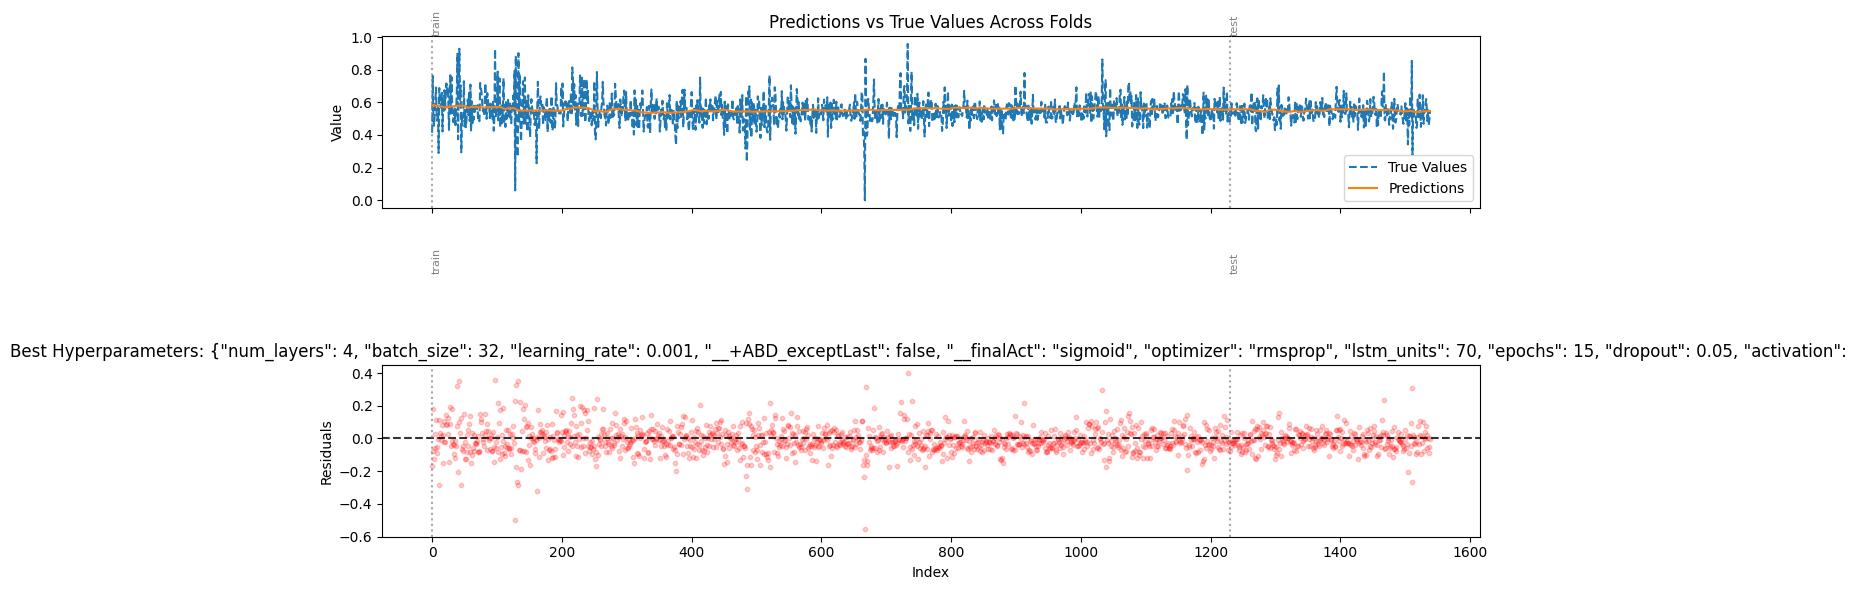

In [5]:
best_hyperparams = study.best_params
best_hyperparams['lstm_units'] = 70  # Add fixed parameters if needed
best_hyperparams['epochs'] = 15
best_hyperparams['dropout'] = 0.05
best_hyperparams['activation'] = 'tanh'
best_hyperparams['layers'] = [best_hyperparams['lstm_units']] * best_hyperparams['num_layers']
best_hyperparams['loss'] = 'mean_squared_error'
best_hyperparams['input_shape'] = latest_entry['train_X_y']['train_X'].shape[1:]

# Create and train the model
best_model = LSTM_returns.create(best_hyperparams)
best_results = LSTM_returns.train(best_model, best_hyperparams, latest_entry['train_X_y'])

# Plot the results
plt = LSTM_returns.all_folds_plot(best_model, latest_entry['train_X_y'])
plt.title(f"Best Hyperparameters: {json.dumps(best_hyperparams)[:200]}")
plt.show()

In [ ]:
joblib.dump(study, 'expt1.5-model-store/study.pkl')